<a href="https://colab.research.google.com/github/verneh/verneh.github.io/blob/master/ULMFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT**

In [0]:
from fastai import *
from fastai.vision import *

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = Path('drive/My Drive/Colab Notebooks/')


In [0]:
# import notebook.
df = pd.read_csv(path/'Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
# shape of our dataset.
df.shape

(14640, 15)

In [0]:
# determine amount of null values.
df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [0]:
# check % of null values.
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [0]:
# we will need to remove more than 90% of null values.
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']

In [0]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**EDA**


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


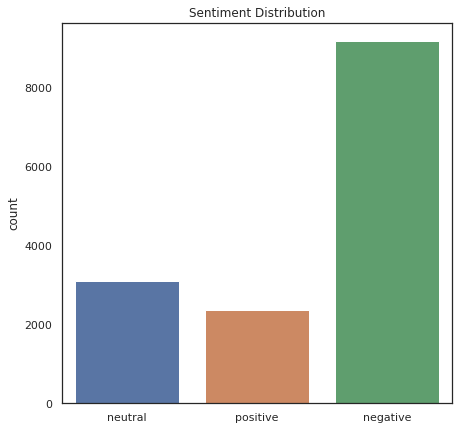

In [0]:
# overall distribution
import seaborn as sns
plt.figure(figsize=(7,7))
sns.set(style="white")
ax = sns.countplot(x="airline_sentiment", data=df)
plt.title('Sentiment Distribution')
plt.xlabel('');


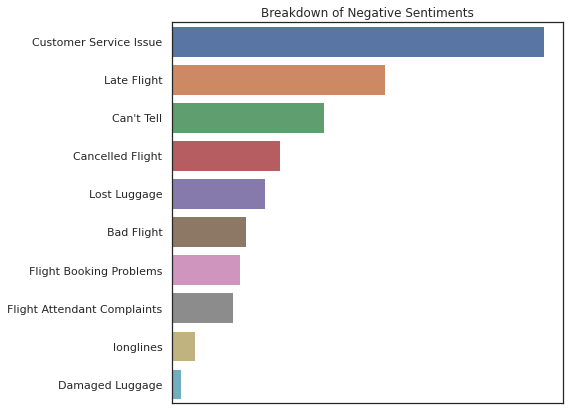

In [0]:
# that's a lot of negative sentiments. what is the composition of the negative sentiments?
plt.figure(figsize=(7,7))
ax = sns.countplot(y='negativereason', data=df, order = df['negativereason'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel("")
plt.xlabel("")
plt.title('Breakdown of Negative Sentiments');

Most of the sentiments come from customer service issues.

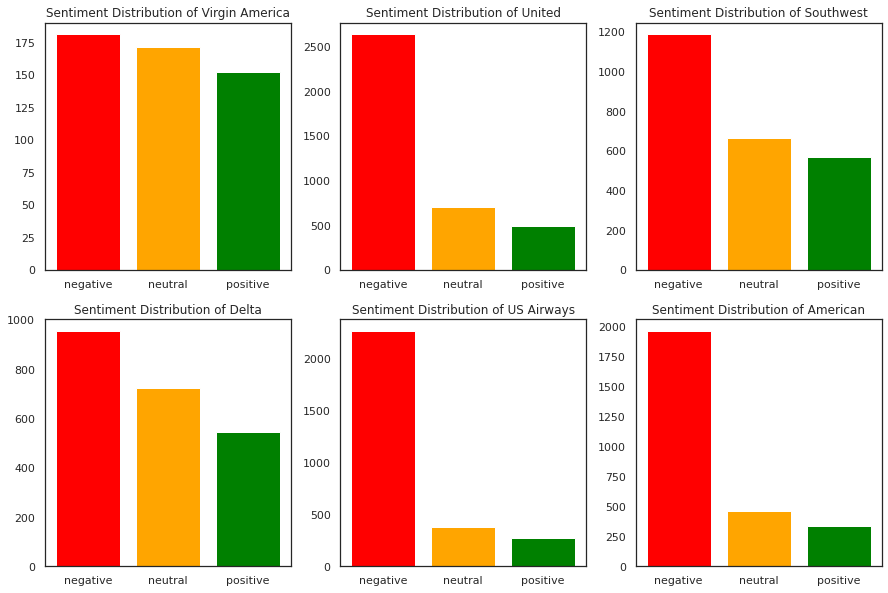

In [0]:
# sentiment distribution by airline
plt.figure(1, figsize=(15,10))
airlines = list(df['airline'].unique())
for i in df.airline.unique():
    idxs = airlines.index(i)
    plt.subplot(2,3,idxs+1)
    pl_df = df[df.airline==i]
    count = pl_df['airline_sentiment'].value_counts()
    index = [1,2,3]
    plt.bar(index, count, color=['red','orange', 'green'])
    plt.xticks(index, ['negative','neutral','positive'])
    plt.ylabel('')
    plt.title('Sentiment Distribution of ' + i)

Most sentiments are negative for majority of the airlines. Virgin America almost has an even distribution. United has the most negative sentiments. Delta with the most neutral, while Southwest has the most positive. 

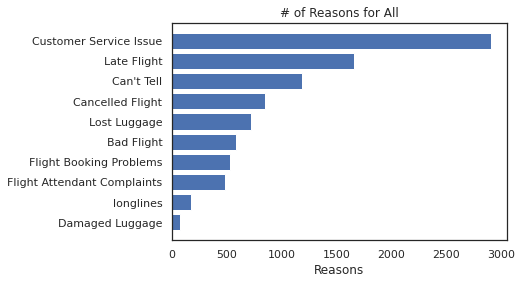

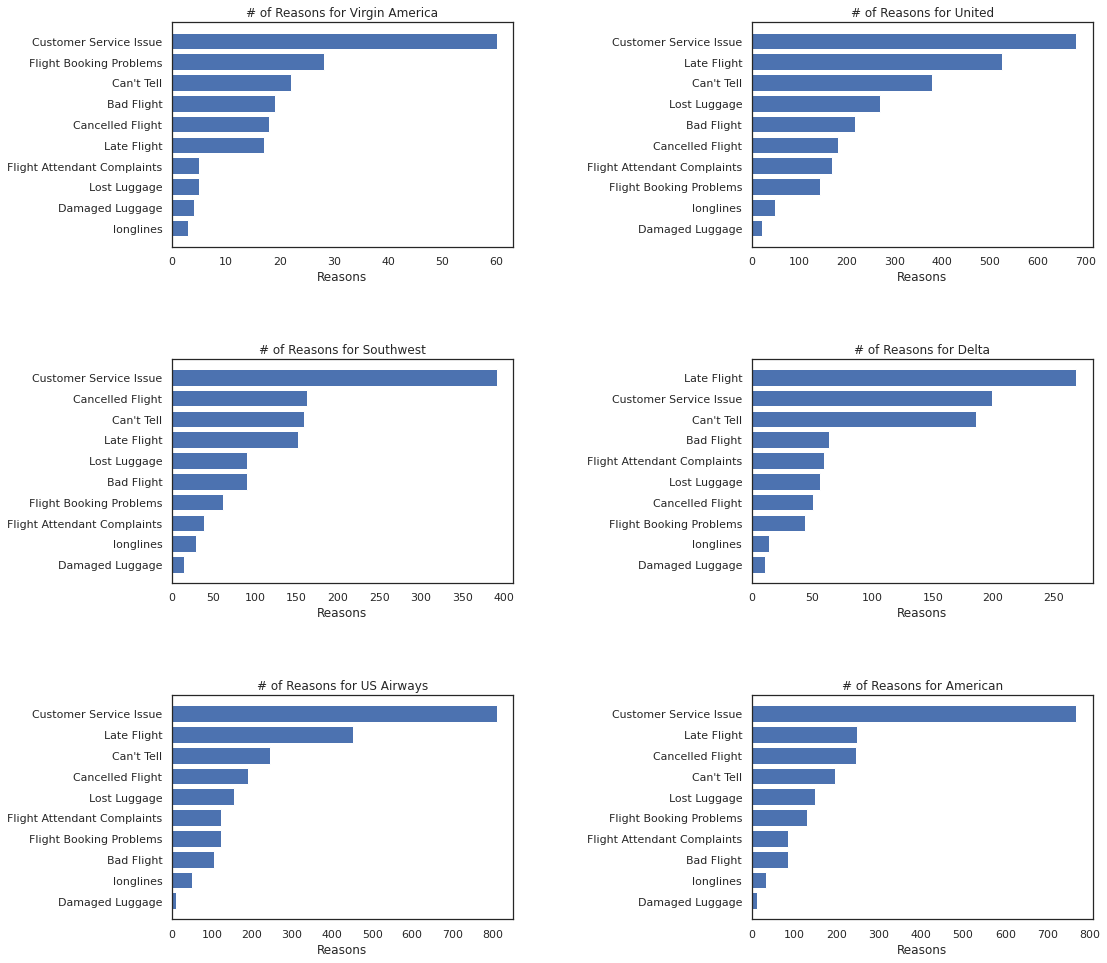

In [0]:
# what are the negative reasons per airline?
df['negativereason'].nunique()

nr_count=dict(df['negativereason'].value_counts(sort=False))

def reason_count(airline):
    if airline=='All':
        a=df
    else:
        a=df[df['airline']==airline]
    count=dict(a['negativereason'].value_counts())
    unique_reason=list(df['negativereason'].unique())
    unique_reason=[x for x in unique_reason if str(x) != 'nan']
    reason_frame=pd.DataFrame({'Reasons':unique_reason})
    reason_frame['count']=reason_frame['Reasons'].apply(lambda x: count[x])
    return reason_frame

def plot_reason(airline):
    
    a=reason_count(airline).sort_values('count')
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.barh(Index,count) # could put color here.
    
    plt.yticks(Index,a['Reasons'],rotation=0)
    plt.ylabel('')
    plt.xlabel('Reasons')
    plt.title('# of Reasons for '+airline)
    
plot_reason('All')
plt.figure(figsize=(16.5, 16.5))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(3,2,indices+1)
    plt.subplots_adjust(hspace=0.5, wspace=0.7)
    plot_reason(i)



As we can see, majority of the reason are due to customer service issues except for Delta - they seem to be having the most issues with late flights.

US Airways has the most customer service issues at 811.

In [0]:
df.groupby(['airline'])['negativereason'].value_counts()

airline         negativereason             
American        Customer Service Issue         768
                Late Flight                    249
                Cancelled Flight               246
                Can't Tell                     198
                Lost Luggage                   149
                Flight Booking Problems        130
                Bad Flight                      87
                Flight Attendant Complaints     87
                longlines                       34
                Damaged Luggage                 12
Delta           Late Flight                    269
                Customer Service Issue         199
                Can't Tell                     186
                Bad Flight                      64
                Flight Attendant Complaints     60
                Lost Luggage                    57
                Cancelled Flight                51
                Flight Booking Problems         44
                longlines             

In [0]:
# Feature filtering
df_filter = df[['airline_sentiment', 'text', 'name','airline']]

In [0]:
# Cleaning text
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

In [0]:
# actual cleaning of text
df_filter['text'] = df_filter.text.map(clean_text)
df_filter.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,airline_sentiment,text,name,airline
0,neutral,virginamerica what dhepburn said,cairdin,Virgin America
1,positive,virginamerica plus youve added commercials to ...,jnardino,Virgin America
2,neutral,virginamerica i didnt today must mean i need t...,yvonnalynn,Virgin America
3,negative,virginamerica its really aggressive to blast o...,jnardino,Virgin America
4,negative,virginamerica and its a really big bad thing a...,jnardino,Virgin America


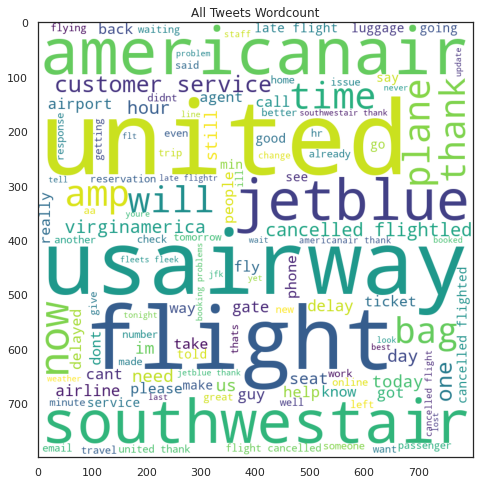

In [0]:
# word count

from wordcloud import WordCloud,STOPWORDS

allcomments = " ".join(df_filter.text)
wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = STOPWORDS, 
                    min_font_size = 12).generate(allcomments) 
      
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.title("All Tweets Wordcount")
plt.show()

This wordcloud after cleaning talked about flight, jetblue, americanair, southwestair, usairway, customer sevice, flight, thank, time, and cancelled flight.

**Modeling**

In [0]:
# We do some label encoding and build a column for label (numeric) for the airline sentiment.
def label(x):
    if x=='negative':
        return -1
    elif x=='positive':
        return 1
    return 0
df_filter['label']=df_filter['airline_sentiment'].apply(label)
df_filter.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,airline_sentiment,text,name,airline,label
0,neutral,virginamerica what dhepburn said,cairdin,Virgin America,0
1,positive,virginamerica plus youve added commercials to ...,jnardino,Virgin America,1
2,neutral,virginamerica i didnt today must mean i need t...,yvonnalynn,Virgin America,0
3,negative,virginamerica its really aggressive to blast o...,jnardino,Virgin America,-1
4,negative,virginamerica and its a really big bad thing a...,jnardino,Virgin America,-1


In [0]:

df_filter['is_valid'] = False
# shuffle
df_filter = df_filter.sample(frac=1).reset_index(drop=True)
df_filter.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,text,name,airline,label,is_valid
0,neutral,americanair please confirm from ciddfw at de...,BF_StarNews,American,0,False
1,positive,southwestair thank u for not leaving me me nic...,DaniMaguina,Southwest,1,False
2,negative,americanair my wife amp infant daughter are on...,nsj,American,-1,False
3,neutral,jetblue flight to boston delayed due to weath...,markmacg1,Delta,0,False
4,positive,united thanks for the reupgrade to class it m...,jasemccarty,United,1,False


The reason we have is valid and label is because we're building a simple classifier here and preparing to setup train df, valid df for modeling

In [0]:
# setting up train_df and valid_df
df_filter[-int(df_filter.shape[0]*0.3):].is_valid = True 
df_filter[-int(df_filter.shape[0]*0.3):].tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,airline_sentiment,text,name,airline,label,is_valid
14635,neutral,americanair ill dm you,LSNorwich,American,0,True
14636,negative,americanair on flight that has been delayed f...,ImagineHC,American,-1,True
14637,neutral,southwestair have a cup coffee and relax while...,dcoadavon,Southwest,0,True
14638,negative,jetblue is there an issue with your website an...,BethRunsDisney,Delta,-1,True
14639,negative,united i need it there before she lands so she...,colbycaterina,United,-1,True


In [0]:
train_df = df_filter[df_filter['is_valid']==False]
valid_df = df_filter[df_filter['is_valid']==True]

**Models**

In [0]:
# setting up sklearn.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score



In [0]:
# we are looking at word token counts here.
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_df['text'])
test_features=v.transform(valid_df['text'])

In [0]:
# multiple classifiers defined here.
classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=250),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

In [0]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in classifiers:
    try:
        fit = classifier.fit(train_features,train_df['label'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train_df['label'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,valid_df['label'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))

Accuracy of LogisticRegression is 0.63091985428051
Accuracy of KNeighborsClassifier is 0.5229963570127505
Accuracy of SVC is 0.63091985428051
Accuracy of DecisionTreeClassifier is 0.6933060109289617
Accuracy of RandomForestClassifier is 0.7634335154826958
Accuracy of AdaBoostClassifier is 0.738615664845173
Accuracy of GaussianNB is 0.48929872495446264


Random Forest provides us with the best accuracy score at 75.4%.

**ULMFit**

In [0]:

# import relevant libs
from fastai.text import *
from sklearn.model_selection import train_test_split

"""
  Function to apply ULMFiT model to the Airline Sentiment
  
  @df: The dataframe with the data
  @test_size: how much data to set aside as test set
  @valid_size: how much data to set aside from training as validation set
  @preprocess: whether or not to preprocess the tweet data
  @lm_dropout: dropout to apply to the language model when fine-tuning
  @classifier_dropout: dropout to apply to the classifier when fine-tuning
  @max_lr_lm: the max learning rate for 1cycle pol. on LM
  @num_cycles_lm_ft: the number of epochs we use to train the LM after
  unfreezing.
  @bs_classifier: batch size for classifier
  @lr_classifier_init: learning rate for first training of classifier
  @epochs_classifier_init: number of epochs we use to train the classifier
  before gradual unfreezing
  @lr_classifier_1:learning rate for training of classifier after 1st unfreeze
  @epochs_classifier_1:number of epochs "                              "
  @lr_classifier_2:learning rate for training of classifier after 2nd unfreeze
  @epochs_classifier_2: number of epochs "                             "
  @lr_classifier_final: learning rate after entire model unfrozen
  @epochs_classifier_final:epochs "                         "
  """

def ulmfit_airline_sentiment(df,test_size=0.1, valid_size=0.1,preprocess=True,
                            lm_dropout=0.3,classifier_dropout=0.5,
                            max_lr_lm=1e-2,num_cycles_lm_ft=5,
                            bs_classifier=32,
                            lr_classifier_init=1e-2,
                             epochs_classifier_init=5,
                             lr_classifier_1=5e-3,
                             epochs_classifier_1=5,
                             lr_classifier_2=5e-3,
                             epochs_classifier_2=5,
                             lr_classifier_final=5e-3,
                             epochs_classifier_final=5
                            ):
  # preprocessing data
  if preprocess:
    print("preprocessing Twitter data")
    preprocessTwitterData(df)
  
  # only need text and airline_sentiment
  df = df[['text','airline_sentiment']]
  
  # split the data into train and test
  df_train, df_test = train_test_split(df,test_size=test_size,random_state=40)
  
  # Convert the cleaned training and testing data
  # into their own CSV files which we can import
  # later to perform modeling on them

  # these lines write CSV files to our current directory
  df_train.to_csv('twitter_data_cleaned_train.csv')
  df_test.to_csv('twitter_data_cleaned_test.csv')
  
  print("Getting LM data into appropriate form")
  # TextMLDataBunch process
  data_lm = TextLMDataBunch.from_csv(path='',
                                     csv_name='twitter_data_cleaned_train.csv',
                                     valid_pct=valid_size)
  
  
  # LM learner
  learn = language_model_learner(data_lm,AWD_LSTM,drop_mult=lm_dropout)
  
  print("Fine-tuning language model")
  # one cycle training, always use moms=(0.85,0.75), always use one epoch on
  # this step to avoid overly fine-tuning
  learn.fit_one_cycle(1,max_lr=max_lr_lm)
  
  # unfreeze LM and do discriminative fine-tuning
  learn.fit_one_cycle(cyc_len=num_cycles_lm_ft, 
                      max_lr=slice(max_lr_lm/(2.6**4),max_lr_lm))
  
  # save the encoding layer
  learn.save_encoder('encoder')
  
  print("LM fine-tuning complete")
  # Start Classifier fine-tuning
  
  print("Getting Classifier data into appropriate form")
  data_class = TextClasDataBunch.from_csv(path='',
                                          csv_name='twitter_data_cleaned_train.csv',
                              vocab=data_lm.train_ds.vocab,
                                          bs=bs_classifier
                                          ,text_cols='text'
                                          ,label_cols='airline_sentiment')
  
  # Classifier Learner
  learn = text_classifier_learner(data_class,AWD_LSTM,
                                  drop_mult=classifier_dropout)
  
  # Load the pretrained encoder into the model
  learn.load_encoder('encoder')
  
  print("Started Classifier fine-tuning")
  # Training before gradual unfreezing
  learn.fit_one_cycle(epochs_classifier_init,lr_classifier_init)
  
  print("Started gradual unfreezing")
  # Start gradual unfreezing process
  
  # unfreeze next layer and train (discriminative layer training)
  learn.freeze_to(-2)
  learn.fit_one_cycle(epochs_classifier_1,
                      slice(lr_classifier_1/(2.6**4),lr_classifier_1))
  
  # unfreeze next layer and train (discriminative layer training)
  learn.freeze_to(-3)
  learn.fit_one_cycle(epochs_classifier_2,
                      slice(lr_classifier_2/(2.6**4),lr_classifier_2))
  
  # unfreeze everything and train
  learn.fit_one_cycle(epochs_classifier_final,
                      slice(lr_classifier_final/(2.6**4),lr_classifier_final))
  
  print("ULMFiT done!")
  # return the model
  return learn

In [0]:
import matplotlib.pyplot as plt
# Taken from the scikit-learn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Getting LM data into appropriate form


Fine-tuning language model


epoch,train_loss,valid_loss,accuracy,time
0,4.756917,4.108711,0.242690,00:14


epoch,train_loss,valid_loss,accuracy,time
0,4.060087,3.927669,0.261635,00:14
1,3.885600,3.806177,0.272210,00:14
2,3.662581,3.756341,0.278265,00:14
3,3.465619,3.740002,0.279994,00:14
4,3.333386,3.737238,0.279911,00:14


LM fine-tuning complete
Getting Classifier data into appropriate form


Started Classifier fine-tuning


epoch,train_loss,valid_loss,accuracy,time
0,0.683482,0.583934,0.759863,00:19
1,0.654931,0.552985,0.772382,00:18
2,0.654213,0.555124,0.771624,00:17
3,0.615231,0.540846,0.775417,00:19
4,0.574561,0.543861,0.777314,00:19


Started gradual unfreezing


epoch,train_loss,valid_loss,accuracy,time
0,0.565451,0.542608,0.780728,00:20
1,0.571822,0.506681,0.801593,00:19
2,0.511098,0.494846,0.808801,00:19
3,0.457024,0.491476,0.807663,00:19
4,0.436493,0.482767,0.814112,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.448890,0.491046,0.808801,00:21
1,0.484961,0.497271,0.797800,00:22
2,0.404117,0.484743,0.815250,00:20
3,0.316414,0.520615,0.818285,00:20
4,0.267231,0.520906,0.821320,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.293388,0.561888,0.814112,00:20
1,0.339326,0.515542,0.809181,00:21
2,0.282310,0.528465,0.819803,00:20
3,0.196232,0.580107,0.819044,00:20
4,0.169222,0.590408,0.819423,00:20


ULMFiT done!
Accuracy: 0.828551912568306


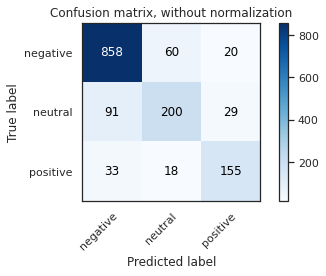

In [0]:
# import metrics from sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# apply function to get learner
learn = ulmfit_airline_sentiment(df,preprocess=False)

# put test data in test df
df_test = pd.read_csv('twitter_data_cleaned_test.csv')

# add a column with the predictions on the test set
df_test['sentiment_pred'] = df_test['text'].apply(lambda row:str(learn.predict(row)[0]))


# print the accuracy against the test set
print("Accuracy: {}".format(accuracy_score(df_test['airline_sentiment'],df_test[
    'sentiment_pred'
])))

# plot the confusion matrix for the test set
plot_confusion_matrix(df_test['airline_sentiment'],df_test['sentiment_pred'],
                      classes=['negative','neutral','positive'])
plt.show()

Peaked at 82.4% Accuracy.

What needs to be improved:
- There's a need to test more methods of hyperparameter testing. 
- There's really just a lot negative sentiments which could create a bias.

Some codes taken from user rajs96, zlapp - github.
